In [1]:
import sys
import os
import time
import pyvisa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binascii import unhexlify
import serial
 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\Drivers")

from Driver_TECSource_5240 import *
from Driver_PM_PM5020 import *
from Driver_OSA_MS9740B import *
from Driver_LaserSource_71440108 import *
from Driver_TSL_Goumax import *

In [2]:
rm = pyvisa.ResourceManager()

tec_zeus = TECSource_5240()
tec_zeus.open(rm,'ASRL15::INSTR')

tec_le = TECSource_5240()
tec_le.open(rm,'ASRL5::INSTR')

pm = PM_PM5020()
pm.open(rm)

osa = OSA_MS9740B()
osa.open(rm)

ld = LaserSource_71440108()
ld.open(rm)

OSA Attenuation Status:  ON



In [3]:
ld.set_output_on(1)

In [120]:
tec_le.set_temperature(45)
tec_le.set_output_on()

In [190]:
T_Start = 23
T_Stop = 55
T_Step = 0.2
t_wait = 5
n = int((T_Stop-T_Start)/T_Step+1)
pm.set_units(1,"W")

wavelength_start = 1565
wavelength_stop = 1585
wavelength_points = 2001
OSA_Resolution = 0.03
OSA_VBW = 1000
timeout = 10000

Light_engine = "22-49-001"
Channel = 4

Bias_current_mA = 50
osa.set_timeout(20000)

In [5]:
def sweepOSA(osa, wavelength_start, wavelength_stop, wavelength_points, OSA_Resolution, OSA_VBW):
    osa.set_wavelength(wavelength_start, wavelength_stop, wavelength_points)
    osa.set_resolution_VBW(OSA_Resolution,OSA_VBW)
    osa.sweep_single()
    Power_list = osa.get_sweep_result()
    Power_list_uW = [None] * len(Power_list)
    for i in range(0,len(Power_list)):
        Power_list_uW[i] = 10**(float(Power_list[i])/10)*1000 
    Wavelength_list = np.linspace(wavelength_start,wavelength_stop,wavelength_points)
    Wavelength_peak_nm, Power_peak_dBm = osa.get_peak()   
    if Power_peak_dBm >= -30:
        SMSR_Linewidth_nm, SMSR_dB = osa.get_SMSR()
        Linewidth_3db_nm = osa.get_linewidth(3)
        Linewidth_20db_nm = osa.get_linewidth(20)
    else:
        SMSR_Linewidth_nm, SMSR_dB = 0, 0
        Linewidth_3db_nm = 0
        Linewidth_20db_nm = 0
    return  Wavelength_list, Power_list, Power_list_uW, Wavelength_peak_nm, Power_peak_dBm, SMSR_Linewidth_nm, SMSR_dB, Linewidth_3db_nm, Linewidth_20db_nm

In [6]:
def sweepOSA_Tx(osa, wavelength_start, wavelength_stop, wavelength_points, OSA_Resolution, OSA_VBW):
    osa.set_wavelength(wavelength_start, wavelength_stop, wavelength_points)
    osa.set_resolution_VBW(OSA_Resolution,OSA_VBW)
    osa.sweep_single()
    Power_list = osa.get_sweep_result()
    Power_list_uW = [None] * len(Power_list)
    for i in range(0,len(Power_list)):
        Power_list_uW[i] = 10**(float(Power_list[i])/10)*1000 
    Wavelength_list = np.linspace(wavelength_start,wavelength_stop,wavelength_points)
    Wavelength_peak_1_nm, Power_peak_1_dBm, Wavelength_peak_2_nm, Power_peak_2_dBm, Wavelength_peak_3_nm, Power_peak_3_dBm = osa.get_3_peaks()   
    if Power_peak_1_dBm >= -30:
        SMSR_Linewidth_nm, SMSR_dB = osa.get_SMSR()
        Linewidth_3db_nm = osa.get_linewidth(3)
        Linewidth_20db_nm = osa.get_linewidth(20)
    else:
        SMSR_Linewidth_nm, SMSR_dB = 0, 0
        Linewidth_3db_nm = 0
        Linewidth_20db_nm = 0
    return  Wavelength_list, Power_list, Power_list_uW, Wavelength_peak_1_nm, Power_peak_1_dBm, Wavelength_peak_2_nm, Power_peak_2_dBm, Wavelength_peak_3_nm, Power_peak_3_dBm, SMSR_Linewidth_nm, SMSR_dB, Linewidth_3db_nm, Linewidth_20db_nm

In [194]:
meas_df = pd.DataFrame()
Voltage_V = ld.get_laser_voltage(Channel)
Temperature = tec_le.get_temperature()
Wavelength_list, Power_list, Power_list_uW, Wavelength_peak_nm, Power_peak_dBm, SMSR_Linewidth_nm, SMSR_dB, Linewidth_3db_nm, Linewidth_20db_nm = sweepOSA(osa, wavelength_start, wavelength_stop, wavelength_points, OSA_Resolution, OSA_VBW)
meas_df_temp = pd.DataFrame({'Light_engine':Light_engine, 'Channel':Channel, 'Bias_current_mA':Bias_current_mA, 'Voltage_V':Voltage_V, 'Temeprature_C':Temperature, 'Wavelength_nm':Wavelength_list, 'Power_dBm':Power_list, 
                            'Power_uW':Power_list_uW, 'Wavelength_peak_nm':Wavelength_peak_nm, 'Power_peak_nm':Power_peak_dBm, 'SMSR_dB':SMSR_dB, 'SMSR_linewidth_nm':SMSR_Linewidth_nm,
                            '3dB_linewidth_nm':Linewidth_3db_nm, '20dB_linewidth_nm':Linewidth_20db_nm})
data = [meas_df_temp, meas_df]
meas_df = pd.concat(data,ignore_index=True,sort=False)

In [197]:
ld.set_output_off(1)
ld.set_output_off(2)
ld.set_output_off(3)
ld.set_output_off(4)

In [180]:
ld.set_output_on(1)
ld.set_output_on(2)
ld.set_output_on(3)
ld.set_output_on(4)

In [101]:
ld.set_laser_current(1,50)

In [195]:
meas_df.to_csv(r"Channel_4_Bias_50_T_45.csv")

In [134]:
tec_zeus.set_output_on()
tec_zeus.set_temperature(30) #40.6

In [169]:
T_Start = 30
T_Stop = 50
T_Step = 0.2
t_wait = 5
n = int((T_Stop-T_Start)/T_Step+1)
pm.set_units(1,"W")

## Measurement Routine (Steady State)

In [161]:
meas_df = pd.DataFrame()
t0 = time.time()
for k in range(0,350,1):
    time.sleep(0.25)
    T_read = tec_zeus.get_temperature()
    Power_read = pm.get_power(1)
    t_meas = time.time()-t0
    dict = {'Time_s':t_meas,'Temperature_C':T_read ,"Power_W":Power_read}
    meas_df_temp = pd.DataFrame([dict])
    data = [meas_df_temp, meas_df]
    meas_df = pd.concat(data,ignore_index=True,sort=False)

## View Plot and Save Data

In [162]:
meas_df.to_csv(r"Power_TX_Temp_45_Lane_23_DC_2.csv")

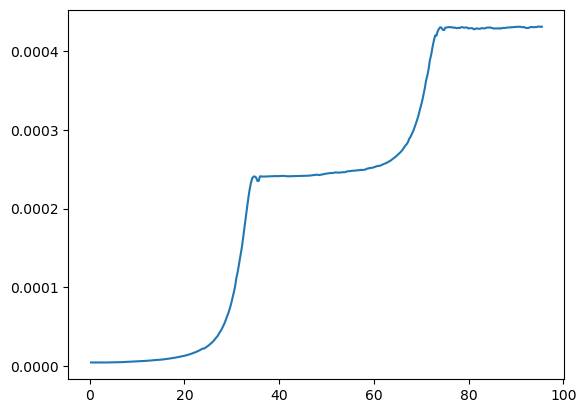

In [163]:
plt.plot(meas_df.Time_s,meas_df.Power_W)

## Measurement Routine (Temperature Ramp)

In [170]:
meas_df = pd.DataFrame()
t0 = time.time()

In [171]:
t1 = time.time()
for k in range(0,n+1,1):
    T_Set = T_Start+k*T_Step
    tec_zeus.set_temperature(T_Set)
    time.sleep(t_wait)
    T_read = tec_zeus.get_temperature()
    Power_read = pm.get_power(1)
    t_meas = time.time()-t0
    dict = {'Time_s':t_meas, 'T_Wait_s':t_wait ,'Temperature_C':T_read ,"Power_W":Power_read}
    meas_df_temp = pd.DataFrame([dict])
    data = [meas_df_temp, meas_df]
    meas_df = pd.concat(data,ignore_index=True,sort=False)

In [176]:
tec_zeus.set_temperature(30)
tec_zeus.set_output_off()

## View, Plot and Save Data

In [172]:
meas_df

,Time_s,T_Wait_s,Temperature_C,Power_W
0,512.882466,5,50.04,0.000028
1,507.864933,5,50.05,0.000029
2,502.841808,5,49.85,0.000028
3,497.821248,5,49.65,0.000029
4,492.796457,5,49.44,0.000030
...,...,...,...,...
97,25.875131,5,30.81,0.000056
98,20.852340,5,30.60,0.000056
99,15.836157,5,30.39,0.000057
100,10.811716,5,30.19,0.000058


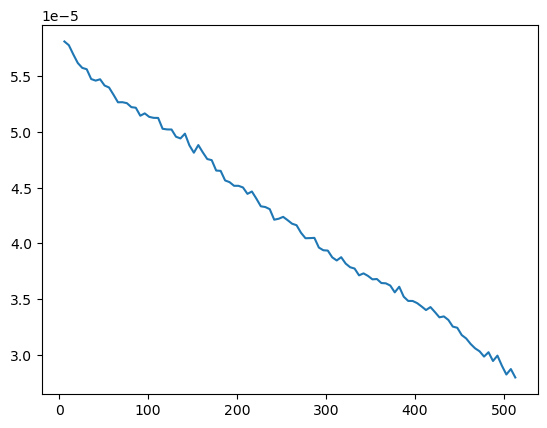

In [173]:
plt.plot(meas_df.Time_s,meas_df.Power_W)

In [174]:
meas_df.to_csv(r"ETX_Ref.csv")

In [198]:
tec_le.set_temperature(25)
tec_le.set_output_off()

In [199]:
osa.close()

In [200]:
tec_zeus.close()

In [201]:
tec_le.close()

In [202]:
pm.close()

In [203]:
ld.close()